# Creación de un modelo inicial

In [1]:
%pip install ucimlrepo
%pip install scikit-learn
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install -U imbalanced-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Carga, transformacion y preparacion de datos

### Carga de los datos

Obtenemos el dataset de para el modelo.

In [2]:
from ucimlrepo import fetch_ucirepo

# Descargar dataset con ID 144
statlog_german_credit_data = fetch_ucirepo(id=144)

# Guardar todo el dataset en un DataFrame
df = statlog_german_credit_data.data.original

# Mostrar las 5 primeras filas
df.head(1)

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,...,Attribute12,Attribute13,Attribute14,Attribute15,Attribute16,Attribute17,Attribute18,Attribute19,Attribute20,class
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1


In [3]:
df = df.rename(columns={
    'Attribute1': 'estado_cuenta',               # Categorical
    'Attribute2': 'duracion_meses',              # Integer
    'Attribute3': 'historial_credito',           # Categorical
    'Attribute4': 'proposito',                    # Categorical
    'Attribute5': 'monto_credito',                # Integer
    'Attribute6': 'cuenta_ahorro_bonos',         # Categorical
    'Attribute7': 'empleo_actual',                # Categorical
    'Attribute8': 'tasa_cuota_ingreso',           # Integer
    'Attribute9': 'estado_civil_sexo',            # Categorical
    'Attribute10': 'otros_deudores_garantes',    # Categorical
    'Attribute11': 'residencia_actual_anios',    # Integer
    'Attribute12': 'propiedad',                    # Categorical
    'Attribute13': 'edad',                         # Integer
    'Attribute14': 'otros_planes_cuotas',         # Categorical
    'Attribute15': 'vivienda',                     # Categorical
    'Attribute16': 'num_creditos_banco',           # Integer
    'Attribute17': 'ocupacion',                    # Categorical
    'Attribute18': 'num_personas_a_cargo',         # Integer
    'Attribute19': 'telefono',                      # Binary
    'Attribute20': 'trabajador_extranjero',         # Binary
    'class': 'buen_mal_credito'                    # Binary (Target)
})

df.head(3)

,estado_cuenta,duracion_meses,historial_credito,proposito,monto_credito,cuenta_ahorro_bonos,empleo_actual,tasa_cuota_ingreso,estado_civil_sexo,otros_deudores_garantes,...,propiedad,edad,otros_planes_cuotas,vivienda,num_creditos_banco,ocupacion,num_personas_a_cargo,telefono,trabajador_extranjero,buen_mal_credito
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1


Agregamos la columna grupo etario

In [4]:
df['grupo_etario'] = '' 

df.loc[df['edad'] < 20, 'grupo_etario'] = '<20'
df.loc[(df['edad'] >= 20) & (df['edad'] < 30), 'grupo_etario'] = '20-29'
df.loc[(df['edad'] >= 30) & (df['edad'] < 40), 'grupo_etario'] = '30-39'
df.loc[(df['edad'] >= 40) & (df['edad'] < 50), 'grupo_etario'] = '40-49'
df.loc[(df['edad'] >= 50) & (df['edad'] < 60), 'grupo_etario'] = '50-59'
df.loc[(df['edad'] >= 60) & (df['edad'] < 70), 'grupo_etario'] = '60-69'
df.loc[(df['edad'] >= 70) & (df['edad'] < 80), 'grupo_etario'] = '70-79'
df.loc[df['edad'] >= 80, 'grupo_etario'] = '+80'

### Transformacion de datos

Primero vamos a separar el estado el atributo combinado estado_civil_sexo, en 2 nuevas columnas, tenemos estos valores de esa columna:

In [5]:
print(df['estado_civil_sexo'].unique())
print('-'*30)
print(df['estado_civil_sexo'].value_counts())

['A93' 'A92' 'A91' 'A94']
------------------------------
estado_civil_sexo
A93    548
A92    310
A94     92
A91     50
Name: count, dtype: int64


#### Personal status and sex

* A91 : male   : divorced/separated
* A92 : female : divorced/separated/married
* A93 : male   : single
* A94 : male   : married/widowed
* A95 : female : single

In [6]:
map_sexo = {
    'A91': 'male',
    'A92': 'female',
    'A93': 'male',
    'A94': 'male',
    'A95': 'female'
}

map_estado_balanceado = {
    'A91': 'not_single',
    'A92': 'not_single',
    'A93': 'single',
    'A94': 'not_single',
    'A95': 'single'
}

Creamos las nuevas columnas

In [7]:
df['estado_civil'] = df['estado_civil_sexo'].map(map_estado_balanceado)
df['sexo'] = df['estado_civil_sexo'].map(map_sexo)


In [8]:
print(df['estado_civil'].value_counts())
print("-"*30)
print(df['sexo'].value_counts())

estado_civil
single        548
not_single    452
Name: count, dtype: int64
------------------------------
sexo
male      690
female    310
Name: count, dtype: int64


In [9]:
# Eliminamos nuestra columna: 'estado_civil_sexo'
df.drop('estado_civil_sexo', axis=1, inplace=True)

### Preparando datos para entrenar

En primer lugar, vamos a transformar el dataset utilizando one-hot encoding para que el clasificador pueda procesarlo correctamente. En un principio, consideramos interpretar algunas variables como ordinales para reducir la cantidad de columnas generadas, pero finalmente decidimos no hacerlo.

Aunque muchas categorías tienen un orden lógico y sus descripciones reflejan los límites entre ellas, el tipo de clasificador que elegimos — árboles de decisión — tiende a interpretar estas categorías ordinales como si unas fueran mejores que otras. 

Queríamos evitar introducir un sesgo de etiqueta artificial en el modelo, por lo que preferimos tratarlas como variables categóricas sin orden implícito. De esta manera, no se asume que una categoría es superior o inferior a otra.

Primero aplicamos encoding a los features

In [10]:
import pandas as pd
features = df.drop('buen_mal_credito', axis=1)
features_encoded = pd.get_dummies(features, dtype=int)

Separando features y target

In [11]:
X = features_encoded
Y = df['buen_mal_credito']

## Eleccion del modelo de clasificación

Como modelo de clasificación, elegimos Random Forest porque consideramos que es el método más efectivo para este tipo de datos. Este modelo es capaz de capturar relaciones no lineales complejas, por lo que nos pareció adecuado evitar modelos que puedan tener dificultades para manejar dicha complejidad.

Además, Random Forest maneja de forma eficiente las variables categóricas codificadas mediante one-hot encoding y es menos propenso al sobreajuste gracias a su naturaleza basada en múltiples árboles y técnicas de bagging.

Para utilizar Random Forest, es necesario transformar las columnas categóricas. En nuestro caso, aplicamos one-hot encoding porque las variables no son ordinales, y queremos evitar que el clasificador interprete un orden que no existe entre las categorías.

## Entrenamiento y evaluación del modelo

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42, stratify=Y) 
# misma proporción de las clases de Y en train y test.

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Definir el modelo base
modelo = RandomForestClassifier(random_state=13)
scoring = {
    'accuracy': 'accuracy',
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'recall_weighted': make_scorer(recall_score, average='weighted')
}

# Definir espacio de hiperparámetros para GridSearch
param_grid = {
    'n_estimators': [15, 20, 50, 100],
    'max_depth': [5, 10, 15, 20, 25],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=modelo,
    param_grid=param_grid,
    scoring=scoring,
    refit='accuracy',  # El criterio para elegir el mejor modelo y refit
    cv=5,
    n_jobs=-1
)


# Ajustar GridSearchCV a los datos de entrenamiento
grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid_search.best_params_)

# Obtener el mejor modelo
best_clf = grid_search.best_estimator_

# Entrenar el mejor modelo con todo el conjunto de entrenamiento
best_clf.fit(X_train, y_train)

# Predecir en conjunto de prueba
y_pred = best_clf.predict(X_test)

# Calcular métricas clásicas para multiclase
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')


Mejores hiperparámetros: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.7640
Precision: 0.7512
Recall: 0.7640
F1-score: 0.7447


## Matriz de confusión

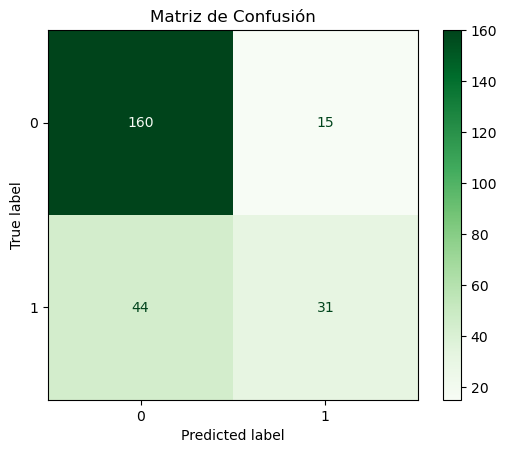

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predecir en conjunto de prueba
y_pred = best_clf.predict(X_test)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión con etiquetas y colores
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.title('Matriz de Confusión')
plt.show()


In [17]:
import math
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier()

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, Y, test_size=0.20, random_state=17, stratify= Y)
rnd_clf.fit(X_train2, y_train2)
y_train_pred2 = rnd_clf.predict(X_train2)


In [18]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


poly_reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    #('poly', PolynomialFeatures()),  # Puedes ajustar los parámetros de PolynomialFeatures aquí
    ('logreg', LogisticRegression(penalty='l1'))#,solver = 'liblinear'))
])

param_grid2 = {
    'logreg__C': [0.00001, 0.001, 0.1, 0.99, 10, 100, 1000000],
    'logreg__class_weight': ['dict', 'balanced'],
    'logreg__solver': ['liblinear', 'saga']
}

# Aplicar GridSearchCV
grid_search2 = GridSearchCV(estimator=poly_reg_pipeline, param_grid=param_grid2, cv=4, scoring='f1_weighted')

# Entrenar el modelo
grid_search2.fit(X_train2, y_train2)


c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: T

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(penalty='l1'))]),
             param_grid={'logreg__C': [1e-05, 0.001, 0.1, 0.99, 10, 100,
                                       1000000],
                         'logreg__class_weight': ['dict', 'balanced'],
                         'logreg__solver': ['liblinear', 'saga']},
             scoring='f1_weighted')

In [19]:
grid_search2.best_params_

{'logreg__C': 0.99,
 'logreg__class_weight': 'balanced',
 'logreg__solver': 'saga'}

In [22]:
grid_search2.best_score_

0.716205753208167

In [23]:
# Obtener el mejor modelo de la búsqueda
best_lr_model_rel = grid_search2.best_estimator_

# Obtener el modelo de regresión logística específico del pipeline
logreg_model = best_lr_model_rel.named_steps['logreg']

# Obtener los coeficientes y el nombre de las columnas originales
coefficients_rel = logreg_model.coef_
columnas = X.columns

# Crear un DataFrame con los coeficientes y las columnas correspondientes
coeficientes_df = pd.DataFrame(data=coefficients_rel, columns=columnas)

# Configurar pandas para mostrar todas las columnas y filas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Imprimir el DataFrame
display(coeficientes_df)


,duracion_meses,monto_credito,tasa_cuota_ingreso,residencia_actual_anios,edad,num_creditos_banco,num_personas_a_cargo,estado_cuenta_A11,estado_cuenta_A12,estado_cuenta_A13,estado_cuenta_A14,historial_credito_A30,historial_credito_A31,historial_credito_A32,historial_credito_A33,historial_credito_A34,proposito_A40,proposito_A41,proposito_A410,proposito_A42,proposito_A43,proposito_A44,proposito_A45,proposito_A46,proposito_A48,proposito_A49,cuenta_ahorro_bonos_A61,cuenta_ahorro_bonos_A62,cuenta_ahorro_bonos_A63,cuenta_ahorro_bonos_A64,cuenta_ahorro_bonos_A65,empleo_actual_A71,empleo_actual_A72,empleo_actual_A73,empleo_actual_A74,empleo_actual_A75,otros_deudores_garantes_A101,otros_deudores_garantes_A102,otros_deudores_garantes_A103,propiedad_A121,propiedad_A122,propiedad_A123,propiedad_A124,otros_planes_cuotas_A141,otros_planes_cuotas_A142,otros_planes_cuotas_A143,vivienda_A151,vivienda_A152,vivienda_A153,ocupacion_A171,ocupacion_A172,ocupacion_A173,ocupacion_A174,telefono_A191,telefono_A192,trabajador_extranjero_A201,trabajador_extranjero_A202,grupo_etario_20-29,grupo_etario_30-39,grupo_etario_40-49,grupo_etario_50-59,grupo_etario_60-69,grupo_etario_70-79,grupo_etario_<20,estado_civil_not_single,estado_civil_single,sexo_female,sexo_male
0,0.228504,0.417285,0.166531,-0.045707,-0.231216,0.097837,0.096739,0.310328,0.147604,-0.098321,-0.514447,0.081043,0.184566,0.0,-0.088274,-0.255668,0.297383,-0.234246,-0.09709,-0.042447,-0.047497,0.015818,0.163731,0.216751,-0.108434,0.054843,0.157493,0.0,0.04859,-0.155593,-0.156879,0.036518,0.058224,0.0,-0.295383,-0.063603,0.0,0.113645,-0.171763,-0.116167,0.005141,0.0,0.0,0.056005,0.019133,-0.244838,0.12761,-0.110011,0.0,-0.125076,0.0,-0.026527,0.028428,0.062634,-0.062634,0.129445,-0.129445,0.0,0.0,-0.030337,0.127542,0.053957,0.0,0.039933,0.127642,-0.127642,-0.02745,0.02745


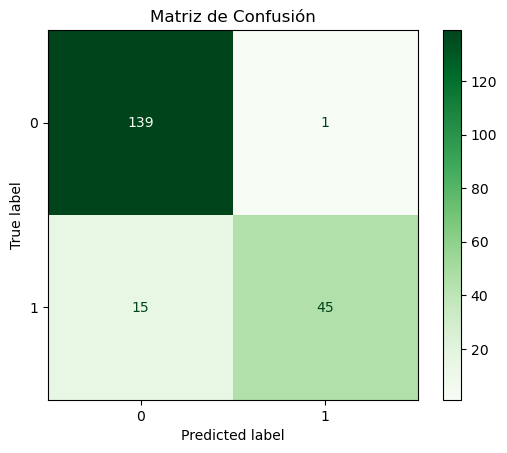

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predecir en conjunto de prueba
y_pred2 = best_clf.predict(X_test2)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test2, y_pred2)

# Mostrar la matriz de confusión con etiquetas y colores
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.title('Matriz de Confusión')
plt.show()

## Interpretacion de resultados

## Justificacion